In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as cores

from matplotlib.pylab import rcParams
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR, AR
import itertools

from graphviz import Digraph

/home/ryuga/anaconda3/envs/PDS/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
cols = {
    'All': ['xmeas{}'.format(col) for col in  np.arange(1, 23)],
    'Causality': ['xmeas{}'.format(col) for col in [2,5,7,9,12,13,14,16]],
    'TransEntropy': ['xmeas{}'.format(col) for col in [5,7,8,11,13,16,20,22]],
    'Reactor': ['xmeas{}'.format(col) for col in [1,2,3,5,6,7,8,9,21]],
    'Stripper': ['xmeas{}'.format(col) for col in [4,5,14,15,16,17,18,19]],
    'Separator': ['xmeas{}'.format(col) for col in [7,10,11,12,13,14,20,22]]
}

op_constraints = ['xmeas{}'.format(col) for col in [7,8,9,12,14]]

In [3]:
data_path = '/home/ryuga/Dropbox/database/dbv3/'
columns = ['tout'] + ['xmeas'+ str(i+1) for i in range(22)]
data_parser = lambda dates: pd.to_datetime(dates, unit='h')

sim_path = {
    'Normal':'data/simout_1.csv',
    'A-C feed ratio': 'data/simout_14.csv',
    'Reactor cooling water inlet temperature': 'data/simout_26.csv',
    'Condenser cooling water inlet temperature': 'data/simout_30.csv',
    'A feed loss': 'data/simout_34.csv'
}

In [4]:
def build_graph(relations):
    cause_effect_graph = Digraph()

    nodes = set([node for relation in relations.index for node in relation])
    for node in nodes:
#       cause_effect_graph.node(node, node, fillcolor='#FFCC00', style='filled')
        cause_effect_graph.node(node, node)

    for relation in relations.index:
        edge_color = "#000000{:02x}".format(int(255 * relations[relation]//relations.max()))
        cause_effect_graph.edge(relation[0],
                                relation[1],
                                color=edge_color)
    
    return cause_effect_graph

def get_relations(df, cols):
    relation_series = pd.Series(index=itertools.product(df.columns, df.columns))
    
    for cause in df[cols].columns:
        for effect in df[cols].columns:
            if cause == effect:
                relation_series[(cause, effect)] = -1
                continue
            pair = [effect, cause]
            tcg = sm.tsa.stattools.grangercausalitytests(df[pair], maxlag=10, verbose=False)
            relation_series[(cause, effect)] = get_best_cause(tcg, signif=.05)

    return relation_series.dropna()


def get_best_cause(test, signif=.05):
    best_stat = -1
    best_p_value = 1
    for lag in test.keys():
        teststatistic = test[lag][0]['params_ftest'][0]
        p_value = test[lag][0]['params_ftest'][1]
        if p_value < signif and p_value < best_p_value:
            best_p_value = p_value
            best_stat = teststatistic
    return best_stat

def plot_stem_corrs(s, labels, figsize=(80, 8), ang_rot_lbls=90):
    x = [i for i in np.arange(0, len(s.index))]
    plt.figure(figsize=figsize)
    plt.stem(s, linefmt='b-', markerfmt='bo', basefmt='r-')
    plt.xticks(x, labels, rotation=ang_rot_lbls)
    plt.show()

def seasonal_decompose_df(df):
    return df.apply(lambda s: seasonal_decompose(s, freq=200)).apply(lambda x: x.resid).transpose().dropna()

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15, 1))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    print('Passed:' , dftest[0] < dftest[4]['1%'])
    
def causality_analysis(sim_condition, col_selection):
    sim_df = pd.read_csv(data_path + sim_path[sim_condition],
                     index_col='tout',
                     usecols=range(23),
                     parse_dates=['tout'],
                     date_parser=data_parser)

    stat_sim_df = seasonal_decompose_df(sim_df)
    relation_series = get_relations(stat_sim_df, cols[col_selection])

    probable_relations = relation_series[relation_series > relation_series.mean() + .1 * relation_series.std()]
    # probable_relations = relation_series[relation_series > 0]
    
    plt.figure(figsize=(16, 4))
    plt.subplot(121)
    probable_relations.sort_values().plot()
    plt.subplot(122)
    relation_series.sort_values().plot()
    plt.show()
    
    cause_effect_graph = build_graph(probable_relations)
    cause_effect_graph.render('graphs/{} - {}'.format(col_selection, sim_condition))
    return cause_effect_graph

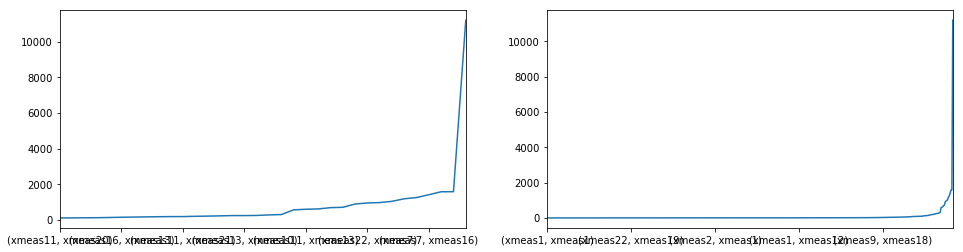

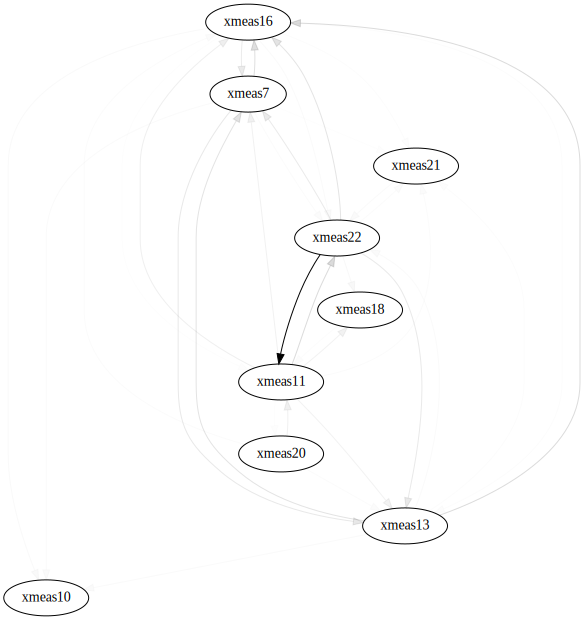

In [5]:
causality_analysis('Normal', 'All')

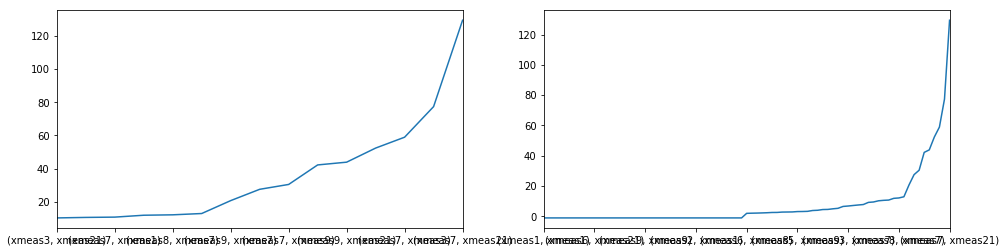

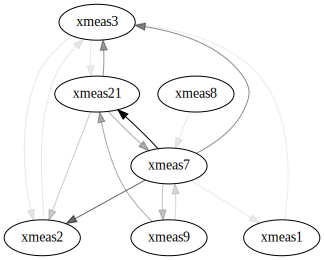

In [6]:
causality_analysis('Normal', 'Reactor')

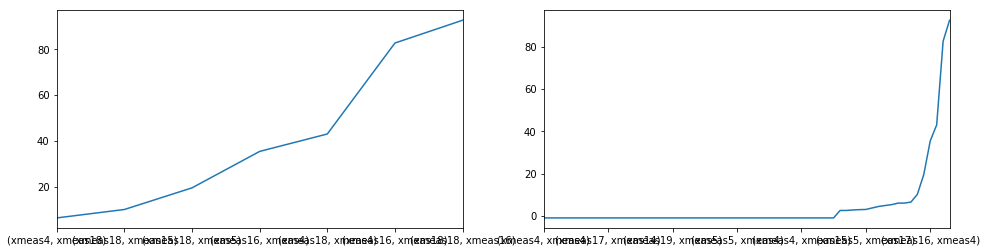

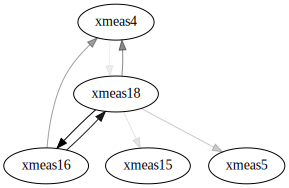

In [7]:
causality_analysis('Normal', 'Stripper')

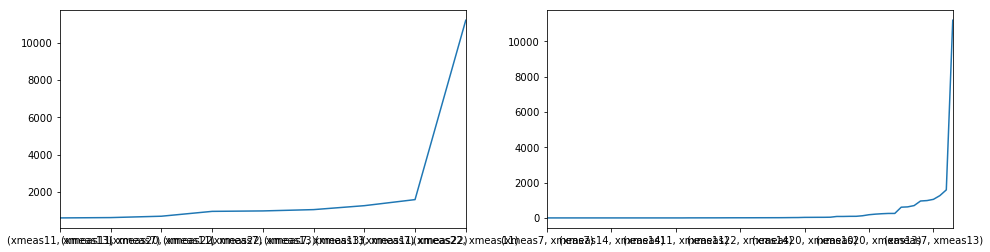

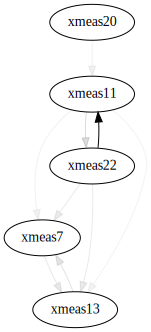

In [8]:
causality_analysis('Normal', 'Separator')

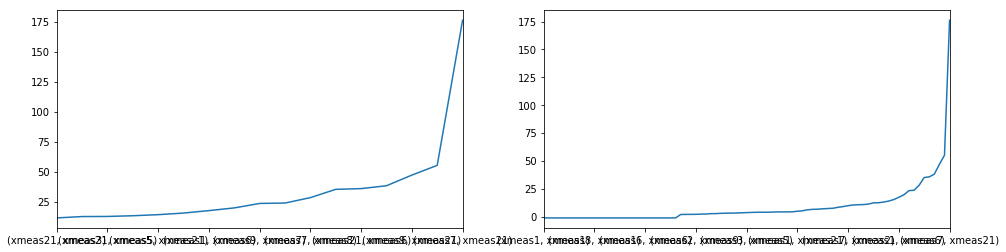

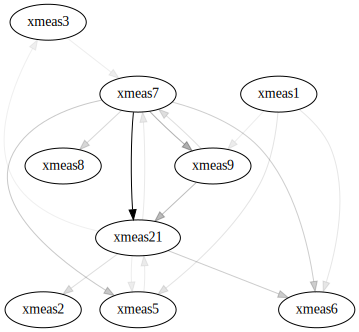

In [9]:
causality_analysis('A/C feed ratio', 'Reactor')

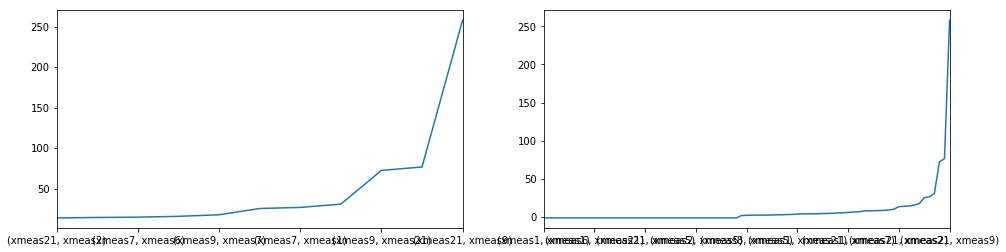

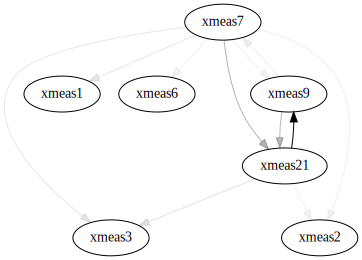

In [10]:
causality_analysis('Reactor cooling water inlet temperature', 'Reactor')

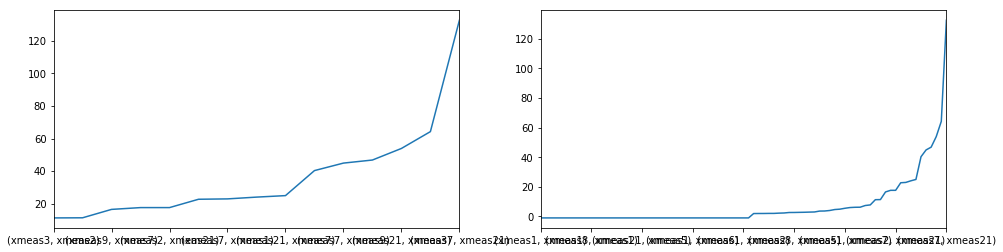

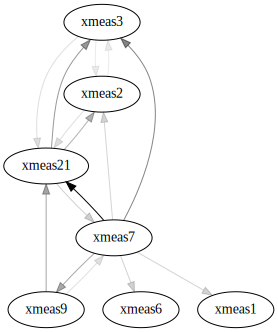

In [11]:
causality_analysis('Condenser cooling water inlet temperature', 'Reactor')